<a href="https://colab.research.google.com/github/bamachrn/car-detection-cv2/blob/main/car_detection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Capstone Project - Computer Vision**
## **Milestone 1**

### **DOMAIN:**
Automotive. Surveillance.
### **CONTEXT:**
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is
predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of
the car, type, colour, number plates etc.
### **DATA DESCRIPTION:**
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g.
2012 Tesla Model S or 2012 BMW M3 coupe.
#### **Data description:**
* **Train Images:** Consists of real images of cars as per the make and year of the 
car.
* **Test Images:** Consists of real images of cars as per the make and year of the car.
* **Train Annotation:** Consists of bounding box region for training images.
* **Test Annotation:** Consists of bounding box region for testing images.
Dataset has been attached along with this project. Please use the same for this capstone project.
<br>Original link to the dataset: https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder
<br>Reference: 3D Object Representations for Fine-Grained Categorisation, Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei 4th IEEE
Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.

### **OBJECTIVE:**
Design a DL based car identification model.

Importing Tensorflow Version

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

Mounting Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Importing Necessary Libraries

In [7]:
import pandas as pd
import numpy as np
import os
import cv2
# Initialize the random number generator
import random
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from glob import iglob
random.seed(0)
# Ignore the warnings
import warnings
# start working with fast.ai
from fastai.vision import *
from fastai.metrics import accuracy, error_rate
from fastai import *
%reload_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")

Defining Project Path

In [8]:
project_path = '/content/drive/My Drive/AIML/Capstone Project/'

Mapping CSV file to Annotation



In [9]:
class_names_data = pd.read_csv(project_path+"names.csv", header=None, names=["class_name"])
train_annotate = pd.read_csv(project_path+"anno_train.csv", header=None, names=["image_file","x0","y0","x1","y1","class"])
test_annotate = pd.read_csv(project_path+"anno_test.csv", header=None, names=["image_file","x0","y0","x1","y1","class"])

In [10]:
#Showing Top 10 label of Class Name
class_names_data.head(10)

,class_name
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [11]:
#Showing Top 10 label of Train Annotation
train_annotate.head(10)

,image_file,x0,y0,x1,y1,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
5,00006.jpg,259,289,515,416,123
6,00007.jpg,88,80,541,397,89
7,00008.jpg,73,79,591,410,96
8,00009.jpg,20,126,1269,771,167
9,00010.jpg,21,110,623,367,58


In [12]:
#Showing Top 10 label of Test Annotation
test_annotate.head(10)

,image_file,x0,y0,x1,y1,class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185
5,00006.jpg,20,77,420,301,78
6,00007.jpg,249,166,2324,1459,118
7,00008.jpg,119,215,1153,719,165
8,00009.jpg,1,7,275,183,32
9,00010.jpg,28,55,241,177,60


In [13]:
#Showing Example of Class Name Which contains Make, Model, Type, Year
class_names_data['class_name'][196%195]

'Acura RL Sedan 2012'

Mapping Class Name file and Train Annotation file




In [14]:
train_annotate['class_name'] = train_annotate.apply(lambda x: class_names_data['class_name'][x['class']%len(class_names_data['class_name'])], axis=1)

In [15]:
#Showing mapping train annotation file
train_annotate

,image_file,x0,y0,x1,y1,class,class_name
0,00001.jpg,39,116,569,375,14,Audi R8 Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Type-S 2008
2,00003.jpg,85,109,601,381,91,Dodge Magnum Wagon 2008
3,00004.jpg,621,393,1484,1096,134,Hyundai Elantra Sedan 2007
4,00005.jpg,14,36,133,99,106,Ford Mustang Convertible 2007
...,...,...,...,...,...,...,...
8139,08140.jpg,3,44,423,336,78,Chrysler 300 SRT-8 2010
8140,08141.jpg,138,150,706,523,196,AM General Hummer SUV 2000
8141,08142.jpg,26,246,660,449,163,Mercedes-Benz E-Class Sedan 2012
8142,08143.jpg,78,526,1489,908,112,Ford F-150 Regular Cab 2012


Defining image path file list

In [16]:
def get_image_file_list(image_path):
  train_image_dir = os.listdir(image_path)
  train_image_list=[]
  for i in train_image_dir:
    for f in os.listdir(os.path.join(image_path, i)):
              # Check file extension. Allow only jpg/jpeg' files.
              ext = os.path.splitext(f)[1]
              if ext == '.jpg' or ext == '.jpeg':
                train_image_list.append("{}/{}".format(i,f))
  return train_image_list

Defining image path list

In [17]:
def map_image_metadata(image_base_path, annotate_metadata, image_path_list):
  image_path_lst_split = [i.split('/')[1] for i in image_path_list]
  annotate_metadata["train_image_path"] = annotate_metadata.apply(
      lambda row: image_base_path+'/'+ image_path_list[image_path_lst_split.index(row['image_file'])], 
      axis=1)
  return annotate_metadata

Mapping Training Annoatation and Image Path

In [18]:
train_image_path = project_path+"car_data/car_data/train"
train_image_list = get_image_file_list(train_image_path)
train_annotate = map_image_metadata(train_image_path, train_annotate, train_image_list)

In [19]:
train_annotate.head(10)

,image_file,x0,y0,x1,y1,class,class_name,train_image_path
0,00001.jpg,39,116,569,375,14,Audi R8 Coupe 2012,/content/drive/My Drive/AIML/Capstone Project/...
1,00002.jpg,36,116,868,587,3,Acura TL Type-S 2008,/content/drive/My Drive/AIML/Capstone Project/...
2,00003.jpg,85,109,601,381,91,Dodge Magnum Wagon 2008,/content/drive/My Drive/AIML/Capstone Project/...
3,00004.jpg,621,393,1484,1096,134,Hyundai Elantra Sedan 2007,/content/drive/My Drive/AIML/Capstone Project/...
4,00005.jpg,14,36,133,99,106,Ford Mustang Convertible 2007,/content/drive/My Drive/AIML/Capstone Project/...
5,00006.jpg,259,289,515,416,123,HUMMER H3T Crew Cab 2010,/content/drive/My Drive/AIML/Capstone Project/...
6,00007.jpg,88,80,541,397,89,Dodge Dakota Crew Cab 2010,/content/drive/My Drive/AIML/Capstone Project/...
7,00008.jpg,73,79,591,410,96,Dodge Charger SRT-8 2009,/content/drive/My Drive/AIML/Capstone Project/...
8,00009.jpg,20,126,1269,771,167,Nissan Leaf Hatchback 2012,/content/drive/My Drive/AIML/Capstone Project/...
9,00010.jpg,21,110,623,367,58,Chevrolet Camaro Convertible 2012,/content/drive/My Drive/AIML/Capstone Project/...


Defining Show Image Function

In [20]:
def show_image(metadata):
  img = cv2.imread(metadata['train_image_path'],1)
  plt.imshow(img)
  plt.show()

Defining Bounding Box function

In [21]:
def show_image_with_bb(df):
  img = cv2.imread(df.train_image_path,1)
  x0=df.x0
  x1=df.x1
  y0=df.y0
  y1=df.y1

  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = patches.Rectangle((x0,y0), (x1-x0),(y1-y0),
                          linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.title(df.class_name)
  plt.show()

Printing Sample Train Image Metadata

In [22]:
df = train_annotate.iloc[8]
df

image_file                                                  00009.jpg
x0                                                                 20
y0                                                                126
x1                                                               1269
y1                                                                771
class                                                             167
class_name                                 Nissan Leaf Hatchback 2012
train_image_path    /content/drive/My Drive/AIML/Capstone Project/...
Name: 8, dtype: object

Showing Sample Train Image

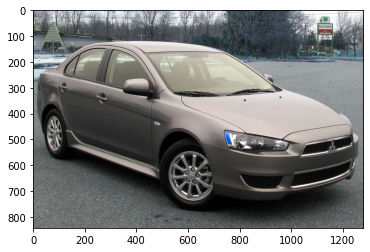

In [23]:
show_image(df)

Showing Image with Bounding Box

In [24]:
df['train_image_path']

'/content/drive/My Drive/AIML/Capstone Project/car_data/car_data/train/Mitsubishi Lancer Sedan 2012/00009.jpg'

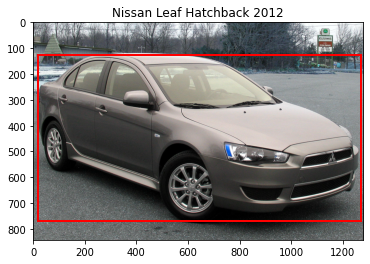

In [25]:
show_image_with_bb(df)

Mapping Test Annotation file to Class Name

In [26]:
test_annotate['class_name'] = test_annotate.apply(lambda x: class_names_data['class_name'][x['class']%len(class_names_data['class_name'])], axis=1)

In [27]:
test_image_path = project_path+"car_data/car_data/test"
test_image_list = get_image_file_list(test_image_path)
test_annotate = map_image_metadata(test_image_path, test_annotate, test_image_list)

In [28]:
df = test_annotate.iloc[10]
df

image_file                                                  00011.jpg
x0                                                                 30
y0                                                                 20
x1                                                                438
y1                                                                253
class                                                              49
class_name                                     Buick Enclave SUV 2012
train_image_path    /content/drive/My Drive/AIML/Capstone Project/...
Name: 10, dtype: object

Showing Sample Test Image

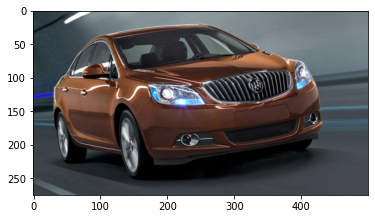

In [29]:
show_image(df)

Showing Sample Test Image with Bounding Box

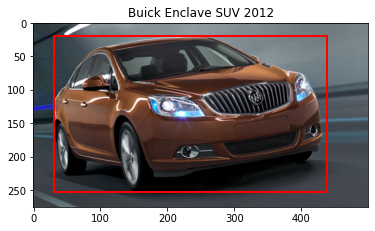

In [30]:
show_image_with_bb(df)

In [31]:
d = test_annotate.iloc[2]
d

image_file                                                  00003.jpg
x0                                                                 51
y0                                                                105
x1                                                                968
y1                                                                659
class                                                             145
class_name                                     Jeep Wrangler SUV 2012
train_image_path    /content/drive/My Drive/AIML/Capstone Project/...
Name: 2, dtype: object

RESNET

In [32]:
# load dataset's location
data_dir='/content/drive/My Drive/AIML/Capstone Project/car_data/car_data'
path = Path(data_dir)

In [33]:
# load databunch object
data = ImageDataBunch.from_folder(path, valid_pct=0.2,
                                  ds_tfms=get_transforms(do_flip=True,flip_vert=False),
                                  size=224,bs=32, num_workers=0).normalize(imagenet_stats)

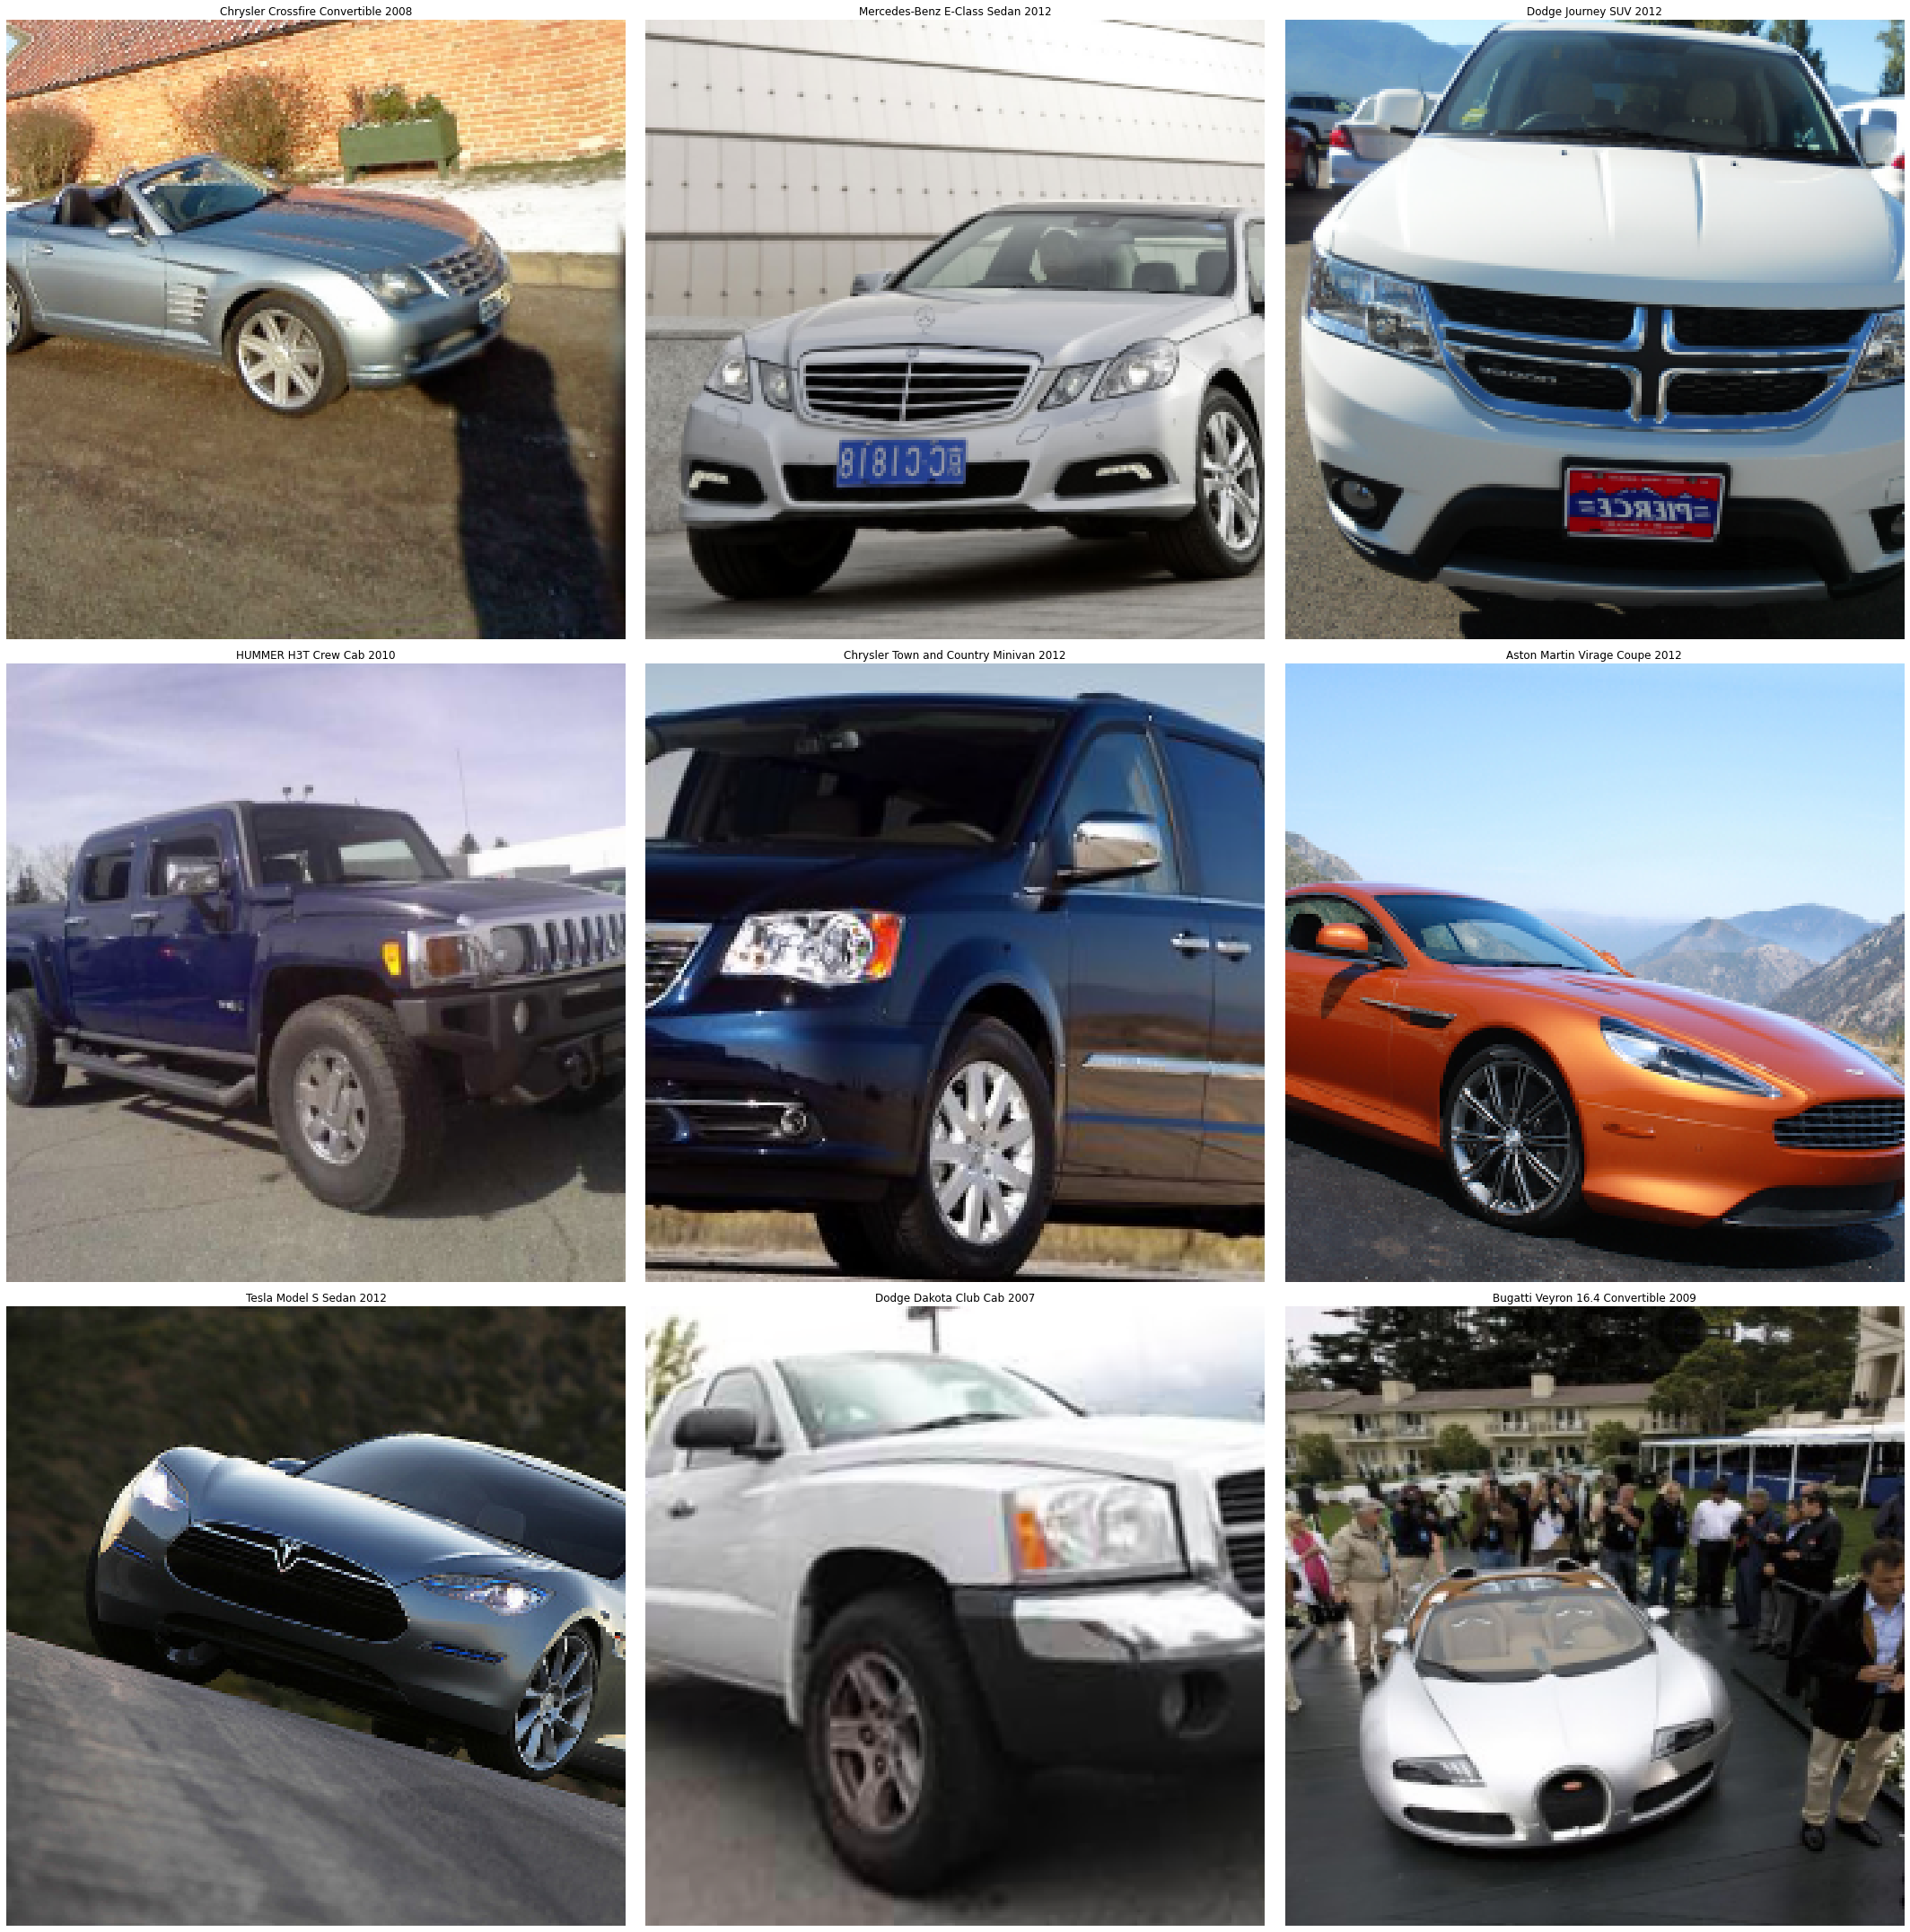

In [34]:
# visualize data
data.show_batch(3, figsize=(30,30))

In [35]:
# create a conv neural network
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


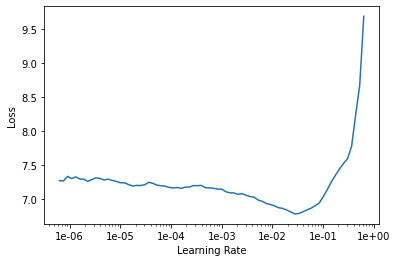

In [36]:
# find the best learning rate for this model against provided dataset
learn.lr_find()
learn.recorder.plot()

In [37]:
# select learning rate
lr = 1e-3

In [38]:
# start training using pre-trained model
learn.fit_one_cycle(25, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time


UnidentifiedImageError: ignored

ValueError: ignored

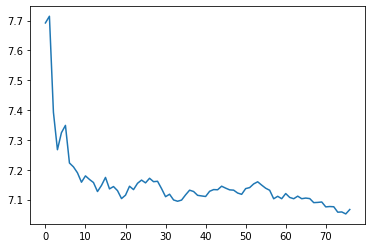

In [39]:
# plot losses
learn.recorder.plot_losses()

In [40]:
# save model
learn.save('model_epoch25_acc87')

# export your model in pickle format
learn.export('car_model.pkl', )